### Salary prediction, episode II: make it actually work (4 points)

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__. Try __at least 3 options__ from the list below for a passing grade. Write a short report about what you have tried. More ideas = more bonus points. 

__Please be serious:__ " plot learning curves in MAE/epoch, compare models based on optimal performance, test one change at a time. You know the drill :)

You can use either __pytorch__ or __tensorflow__ or any other framework (e.g. pure __keras__). Feel free to adapt the seminar code for your needs. For tensorflow version, consider `seminar_tf2.ipynb` as a starting point.


In [127]:
from collections import Counter

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import torch
import torch.functional as F
import torch.nn as nn
from nltk.tokenize import TweetTokenizer
from scipy.stats import beta, shapiro
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

%matplotlib inline

SEED = 42

## Reading data

In [2]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data.drop(["LocationRaw", "SalaryRaw", "SourceName", "Id"], axis=1, inplace=True)
data.shape

(244768, 8)

In [3]:
data.head()

,Title,FullDescription,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryNormalized
0,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,25000
1,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,30000
2,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,30000
3,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,27500
4,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000


### Missing values 

In [4]:
data.isna().sum()

Title                      1
FullDescription            0
LocationNormalized         0
ContractType          179326
ContractTime           63905
Company                32430
Category                   0
SalaryNormalized           0
dtype: int64

In [5]:
text_columns = ["Title", "FullDescription"]
categorical_columns = [
    "Category",
    "Company",
    "LocationNormalized",
    "ContractType",
    "ContractTime",
]
target_column = "SalaryNormalized"

For now, let's just fill all the `NA` values with `NaN` 

In [6]:
data = data.fillna("NaN")

## Splitting data

In [7]:
data_train, data_val = train_test_split(data, test_size=0.2, random_state=SEED)
data_train.reset_index(drop=True, inplace=True)
data_val.reset_index(drop=True, inplace=True)

data_train.shape, data_val.shape

((195814, 8), (48954, 8))

## Looking at data

In [8]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195814 entries, 0 to 195813
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Title               195814 non-null  object
 1   FullDescription     195814 non-null  object
 2   LocationNormalized  195814 non-null  object
 3   ContractType        195814 non-null  object
 4   ContractTime        195814 non-null  object
 5   Company             195814 non-null  object
 6   Category            195814 non-null  object
 7   SalaryNormalized    195814 non-null  int64 
dtypes: int64(1), object(7)
memory usage: 12.0+ MB


#### Target

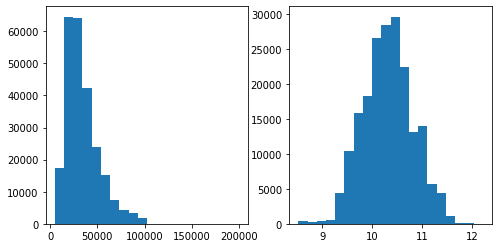

In [9]:
log1pSalary = np.log1p(data_train["SalaryNormalized"]).astype("float32")

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20)

plt.subplot(1, 2, 2)
plt.hist(log1pSalary, bins=20);

The lognormal distribution is suitable for describing salaries, price of securities, urban population, number of comments on articles on the internet, etc.

In [10]:
shapiro(log1pSalary)

C:\Users\ryblo\Documents\projects\yandex_nlp_course\venv\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9969059824943542, pvalue=2.802596928649634e-45)

#### Categorical columns

In [11]:
for cat_column in categorical_columns:
    print(
        f"'{cat_column}' column contains {data_train[cat_column].nunique()} unique values"
    )

'Category' column contains 29 unique values
'Company' column contains 18857 unique values
'LocationNormalized' column contains 2543 unique values
'ContractType' column contains 3 unique values
'ContractTime' column contains 3 unique values


##### Category column

In [12]:
data_train["Category"].value_counts()

IT Jobs                             30847
Engineering Jobs                    20159
Accounting & Finance Jobs           17434
Healthcare & Nursing Jobs           16916
Sales Jobs                          13849
Other/General Jobs                  13567
Teaching Jobs                       10137
Hospitality & Catering Jobs          9066
Trade & Construction Jobs            7088
PR, Advertising & Marketing Jobs     7070
HR & Recruitment Jobs                6190
Admin Jobs                           6112
Retail Jobs                          5201
Customer Services Jobs               4794
Legal Jobs                           3145
Manufacturing Jobs                   3027
Logistics & Warehouse Jobs           2912
Social work Jobs                     2743
Consultancy Jobs                     2591
Travel Jobs                          2508
Scientific & QA Jobs                 2010
Charity & Voluntary Jobs             1867
Energy, Oil & Gas Jobs               1821
Creative & Design Jobs            

##### Company column

In [13]:
data_train["Company"].value_counts()

NaN                                                      25884
UKStaffsearch                                             4015
CVbrowser                                                 2387
London4Jobs                                               1859
Hays                                                      1424
                                                         ...  
Oxford University Hospitals NHS Trust                        1
Aspirations Care                                             1
MANPOWER UK LTD                                              1
Zolv.com Ltd                                                 1
The Facial Surgery Research Foundation   Saving Faces        1
Name: Company, Length: 18857, dtype: int64

##### LocationNormalized column

In [14]:
data_train["LocationNormalized"].value_counts()

UK                   32767
London               24483
South East London     9411
The City              5337
Manchester            2859
                     ...  
Kilbarchan               1
Brompton                 1
Kennoway                 1
Kirkby Stephen           1
Grimethorpe              1
Name: LocationNormalized, Length: 2543, dtype: int64

##### ContractType column

In [15]:
data_train["ContractType"].value_counts()

NaN          143245
full_time     46208
part_time      6361
Name: ContractType, dtype: int64

##### ContractTime column

In [16]:
data_train["ContractTime"].value_counts()

permanent    121042
NaN           51332
contract      23440
Name: ContractTime, dtype: int64

## Preparing

### Tokenizer

In [17]:
# tokenizer = TweetTokenizer()
tokenizer = nltk.tokenize.WordPunctTokenizer()

# assert tokenizer.tokenize("I've been doing this for a few years!") == [
#     "I've",
#     "been",
#     "doing",
#     "this",
#     "for",
#     "a",
#     "few",
#     "years",
#     "!",
# ]

## Preprocessor Class

In [61]:
class PreprocessDataset:
    TEXT_COLS = ["Title", "FullDescription"]
    CAT_COLS = [
        "Category",
        "Company",
        "LocationNormalized",
        "ContractType",
        "ContractTime",
    ]
    TARGET_COL = "SalaryNormalized"
    NEW_TARGET_COL = "Log1pSalary"
    UNK, PAD = "UNK", "PAD"
    SEED = 42

    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer,
        min_count=10,
        max_len_title=None,
        max_len_description=None,
    ):
        self.tokenizer = tokenizer
        self.data = data

        self.data_train, self.data_val = self._split_data()

        self.data_train = self.preprocess_data(self.data_train, train=True)
        self.data_val = self.preprocess_data(self.data_val)

        self.categorical_vectorizer = self._preprocess_categorical()
        self.vocab = self._build_vocab(min_count)
        self.token_to_id = self._build_token_to_id_dict()
        self.UNK_IX, self.PAD_IX = map(self.token_to_id.get, [self.UNK, self.PAD])
        self.max_len_description = max_len_description
        self.max_len_title = max_len_title

    def preprocess_data(self, data, train=False):
        print(f"Preprocessing {'Train' if train else 'Val'} data")
        data = self._preprocess_texts(data)
        data = self._preprocess_target(data)

        return data

    def _split_data(self, test_size=0.2):
        print("Splitting data to train and val sets")
        data_train, data_val = train_test_split(
            self.data, test_size=test_size, random_state=self.SEED
        )
        data_train.reset_index(drop=True, inplace=True)
        data_val.reset_index(drop=True, inplace=True)

        return data_train, data_val

    def _preprocess_texts(self, data: pd.DataFrame) -> pd.DataFrame:
        for text_col in self.TEXT_COLS:
            tqdm.pandas(desc=f"Tokenizing {text_col}")
            tokenized_texts = data[text_col].progress_apply(self._tokenize)
            data[text_col] = tokenized_texts.values

        return data

    def _preprocess_target(self, data: pd.DataFrame) -> pd.DataFrame:
        print("Preprocessing Target column")
        data[self.NEW_TARGET_COL] = np.log1p(data[self.TARGET_COL]).astype("float32")

        return data

    def _preprocess_categorical(self, most_common=1000):
        print("Preprocessing Categorical columns")

        tqdm.pandas(desc=f"Preprocessing Company column")
        # we only consider top-1k most frequent companies to minimize memory usage
        top_companies, top_counts = zip(
            *Counter(self.data_train["Company"]).most_common(most_common)
        )
        recognized_companies = set(top_companies)
        self.data_train["Company"] = self.data_train["Company"].progress_apply(
            lambda comp: comp if comp in recognized_companies else "Other"
        )

        tqdm.pandas(desc=f"Vectorizing categorical columns")
        categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
        categorical_vectorizer.fit(
            self.data_train[self.CAT_COLS].progress_apply(dict, axis=1)
        )

        return categorical_vectorizer

    def _build_vocab(self, min_count):
        token_counts = Counter()

        # Count how many times does each token occur in both "Title" and "FullDescription" in total
        for str_ in tqdm(
            self.data_train[text_columns].values.flatten(), desc="Building vocab"
        ):
            token_counts.update(str(str_).split())

        print("Total unique tokens :", len(token_counts))
        print("\n".join(map(str, token_counts.most_common(n=5))))
        print("...")
        print("\n".join(map(str, token_counts.most_common()[-3:])))

        # tokens from token_counts keys that had at least min_count occurrences throughout the dataset
        tokens = sorted(t for t, c in token_counts.items() if c >= min_count)

        # Add a special tokens for unknown and empty words
        tokens = [self.UNK, self.PAD] + tokens

        print("Vocabulary size:", len(tokens))
        assert type(tokens) == list
        assert len(tokens) in range(30000, 35000)
        assert "me" in tokens
        assert self.UNK in tokens

        return tokens

    def _build_token_to_id_dict(self):
        token_to_id = {token: i for i, token in enumerate(self.vocab)}

        assert isinstance(token_to_id, dict)
        assert len(token_to_id) == len(self.vocab)
        for token in self.vocab:
            assert self.vocab[token_to_id[token]] == token

        return token_to_id

    def _tokenize(self, text):
        return " ".join(self.tokenizer.tokenize(str(text).lower()))

    def _as_matrix(self, sequences, max_len=None):
        """Convert a list of tokens into a matrix with padding"""

        if isinstance(sequences[0], str):
            sequences = list(map(str.split, sequences))

        max_len = min(max(map(len, sequences)), max_len or float("inf"))

        matrix = np.full((len(sequences), max_len), np.int32(self.PAD_IX))

        for i, seq in enumerate(sequences):
            row_ix = [self.token_to_id.get(word, self.UNK_IX) for word in seq[:max_len]]
            matrix[i, : len(row_ix)] = row_ix

        return matrix

    def _encode_categorical(self, data):
        pass

In [62]:
preprocessor = PreprocessDataset(
    data, tokenizer, max_len_title=10, max_len_description=100
)

Splitting data to train and val sets
Preprocessing Train data


Tokenizing Title:   0%|          | 0/195814 [00:00<?, ?it/s]

Tokenizing FullDescription:   0%|          | 0/195814 [00:00<?, ?it/s]

Preprocessing Target column
Preprocessing Val data


Tokenizing Title:   0%|          | 0/48954 [00:00<?, ?it/s]

Tokenizing FullDescription:   0%|          | 0/48954 [00:00<?, ?it/s]

Preprocessing Target column
Preprocessing Categorical columns


Preprocessing Company column:   0%|          | 0/195814 [00:00<?, ?it/s]

Vectorizing categorical columns:   0%|          | 0/195814 [00:00<?, ?it/s]

Building vocab:   0%|          | 0/391628 [00:00<?, ?it/s]

Total unique tokens : 179241
('and', 2123096)
('.', 2018563)
(',', 1853938)
('the', 1663289)
('to', 1613615)
...
('pate', 1)
('nurseportadown', 1)
('salesexecutivesx2northwestlondonesp', 1)
Vocabulary size: 30715


## Dataset & Dataloaders & Transforms

We will pass training data with parameter `train=True` with which we will fit our vectorizers and so on and test data with `train=False` with which we will transform our test dataset  
Create one class for dataset preprocessing and another class for using preprocessed dataset for dataloaders

### Transforms

In [125]:
class ApplyWordDropout:
    def __init__(self, replace_with, pad_ix, word_dropout=0.0):
        self.keep_prop = 1.0 - word_dropout
        self.replace_with = replace_with
        self.pad_ix = pad_ix

    def apply_word_dropout(self, matrix):
        dropout_mask = np.random.choice(
            2, np.shape(matrix), p=[self.keep_prop, 1 - self.keep_prop]
        )
        dropout_mask &= matrix != self.pad_ix

        return np.choose(
            dropout_mask, [matrix, np.full_like(matrix, self.replace_with)]
        )

    def __call__(self, sample):
        return self.apply_word_dropout(sample)


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        sample_tensors = dict()
        for key, arr in sample.items():
            if key in ["FullDescription", "Title"]:
                sample_tensors[key] = torch.tensor(arr, dtype=torch.int64)
            else:
                sample_tensors[key] = torch.tensor(arr)
        return sample_tensors

### Dataset

In [111]:
class VacancyDataset:
    def __init__(self, preprocessor, train=True, transform=None, word_dropout=0):
        self.preprocessor = preprocessor

        self.data = self.preprocessor.data_train if train else preprocessor.data_val
        self.transform = transform
        self.word_dropout = ApplyWordDropout(
            replace_with=self.preprocessor.UNK_IX,
            pad_ix=self.preprocessor.PAD_IX,
            word_dropout=word_dropout,
        )

        self.title = self.preprocessor._as_matrix(
            self.data["Title"].values, self.preprocessor.max_len_title
        )
        self.description = self.preprocessor._as_matrix(
            self.data["FullDescription"].values,
            self.preprocessor.max_len_description,
        )

        if word_dropout != 0:
            self.description = self.word_dropout(self.description)

        self.categorical = self.preprocessor.categorical_vectorizer.transform(
            self.data[self.preprocessor.CAT_COLS].apply(dict, axis=1)
        )

        self.target = self.data[self.preprocessor.NEW_TARGET_COL]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = {}
        sample["title_text"] = self.title[idx]
        sample["description_text"] = self.description[idx]
        sample["categorical"] = self.categorical[idx]
        sample["target"] = self.target[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample

In [119]:
training_data = VacancyDataset(preprocessor, train=True, transform=ToTensor())
test_data = VacancyDataset(preprocessor, train=False, transform=ToTensor())

In [124]:
train_dataset[0]

{'title_text': tensor([24819, 26849, 30286,     1,     1,     1,     1,     1,     1,     1],
        dtype=torch.int32),
 'description_text': tensor([24819, 26849, 30286, 29617,   859, 24819, 26849, 30286, 14791, 29617,
         11324,   859, 23413, 24907, 13981,     0,   143, 25745,   143, 11324,
         23414, 30179, 15968,  8291,   143, 20864,  8380,   143,  1149,  4019,
         14271,  1954,     0, 21746,   153, 27623, 13746,  4713, 30067, 12822,
          9362,  1911, 19266,   106, 30179,  2611, 15980,   859, 30533, 10383,
         30190, 27718, 10914,   143, 21490,  2611,   859, 24819, 16101,   153,
         27623, 24819, 26849, 30286, 30067, 12822, 27940,  3250,   932, 27940,
          6234,  1954, 13935,  4811, 21011,   143,  2400, 29834,  2400,  2338,
         14109,  7484, 19956,  1954,  9629, 23414, 27940, 27148,  1911,  1183,
         23904, 13981,  1703,  2475, 19427,  7484, 16370,  1954,  9768, 27623],
        dtype=torch.int32),
 'categorical': tensor([0., 0., 0.,  ..

### Dataloaders

In [121]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [122]:
batch = next(iter(train_dataloader))

In [123]:
batch

{'title_text': tensor([[23673, 23348,    74, 20597, 13463,  8015,     1,     1,     1,     1],
         [29195, 27376,     1,     1,     1,     1,     1,     1,     1,     1],
         [ 4464,  8146, 16929, 19103,  1954, 25812,     1,     1,     1,     1],
         [ 5115,  8883,     1,     1,     1,     1,     1,     1,     1,     1],
         [25915, 27389,     1,     1,     1,     1,     1,     1,     1,     1],
         [27364,  6568,    30, 16101,   609,    58,     1,     1,     1,     1],
         [17217, 27306, 18661,     1,     1,     1,     1,     1,     1,     1],
         [19248, 13334, 16929,     1,     1,     1,     1,     1,     1,     1],
         [ 4464, 28298,  6568, 20280, 27843,     1,     1,     1,     1,     1],
         [ 4464,  8146, 10285,     1,     1,     1,     1,     1,     1,     1],
         [27086,  1319,   143, 30115,   143, 16297,   143,    74, 15313,     1],
         [ 6671, 27086,  9703,     1,     1,     1,     1,     1,     1,     1],
         [1967

### A short report

Please tell us what you did and how did it work.

`<YOUR_TEXT_HERE>`, i guess...

## Recommended options

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm*`/`L.BatchNormalization`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to perform pooling:
* Max over time (independently for each feature)
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a dense layer.

The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$ (aka multi-headed attention).

The catch is that keras layers do not inlude those toys. You will have to [write your own keras layer](https://keras.io/layers/writing-your-own-keras-layers/). Or use pure tensorflow, it might even be easier :)

#### C) Fun with words

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained embeddings from `gensim.downloader.load`. See last lecture.
* Start with pre-trained embeddings, then fine-tune them with gradient descent. You may or may not download pre-trained embeddings from [here](http://nlp.stanford.edu/data/glove.6B.zip) and follow this [manual](https://keras.io/examples/nlp/pretrained_word_embeddings/) to initialize your Keras embedding layer with downloaded weights.
* Use the same embedding matrix in title and desc vectorizer


#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [early stopping callback(keras)](https://keras.io/callbacks/#earlystopping) or in [pytorch(lightning)](https://pytorch-lightning.readthedocs.io/en/latest/common/early_stopping.html).
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.save(file_name)`
  * Plotting learning curves is usually a good idea
  
Good luck! And may the force be with you!

# Questions

* Why did we use `max_len = 10` for `FullDescription` column?  
The text size in this column is so much bigger
* Why do we treat `Company` and `Title` differently?
* Investigate lengths for `Title` and `FullDescription` columns